In [3]:
import sys
import yaml
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import psfmachine as pm
import lightkurve as lk
from astropy.io import fits
from scipy import stats
from astropy.table import Table

ModuleNotFoundError: No module named 'matplotlib'

# Test Background Rolling Band

## TPF background pixels

In [3]:
tpfs = lk.search_targetpixelfile("KIC 9150728", mission="Kepler", 
                                 quarter=5, cadence="long", 
                                 radius=1000, limit=200).download_all()
len(tpfs)

200

In [4]:
tpfs[0].header

<ipython-input-4-1cfd61e82383>:1: LightkurveDeprecationWarning: The header function is deprecated and may be removed in a future version.
        Use get_header() instead.
  tpfs[0].header


SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-18'         / file creation date.                            
CREATOR = '894994 TargetPixelExporterPipelineModule' / pipeline job and program 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.23 r60353' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In [10]:
machine = pm.TPFMachine.from_TPFs(tpfs, dr=13, magnitude_limit=19)
machine

<__array_function__ internals>:5: RuntimeWarning: All-NaN axis encountered


TPFMachine (N sources, N times, N pixels): (387, 4487, 4842)

In [154]:
machine.tpf_meta["quarter"][0]

5

<ipython-input-8-0808a84c9704>:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter(machine.ra, machine.dec, c=np.log10(machine.flux[0]), s=3);


(45.4, 45.6)

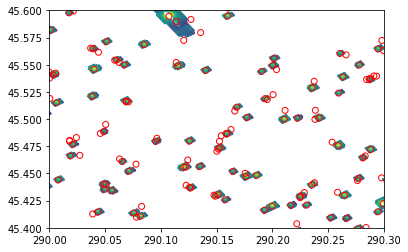

In [8]:
plt.scatter(machine.ra, machine.dec, c=np.log10(machine.flux[0]), s=3);
plt.scatter(machine.sources.ra, machine.sources.dec, marker="o", facecolors="none",
                edgecolors="r",)
plt.xlim(290,290.3)
plt.ylim(45.4, 45.6)

/Users/jorgemarpa/Work/BAERI/ADAP/psfmachine/src/psfmachine/machine.py:392: RuntimeWarning: divide by zero encountered in log10
  f = np.log10((temp_mask.astype(float) * mean_flux))
/Users/jorgemarpa/Work/BAERI/ADAP/psfmachine/src/psfmachine/machine.py:1051: RuntimeWarning: invalid value encountered in sqrt
  .multiply((f ** 0.5) / (f * np.log(10)))
/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


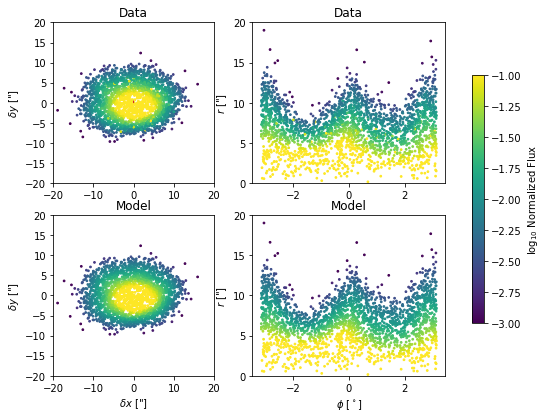

In [13]:
machine.build_shape_model(plot=True);

In [69]:
bkg_pix = ~np.asarray((machine.source_mask.todense()).sum(axis=0).astype(bool)).ravel()
bkg_pix.shape

bkg_col = machine.column[bkg_pix]
bkg_row = machine.row[bkg_pix]
bkg_flux = machine.flux[:, bkg_pix]
bkg_fluxe = machine.flux_err[:, bkg_pix]

<ipython-input-323-374e974e1001>:2: RuntimeWarning: invalid value encountered in log10
  cbar = plt.scatter(bkg_col, bkg_row, c=np.log10(bkg_flx[0]), s=1);


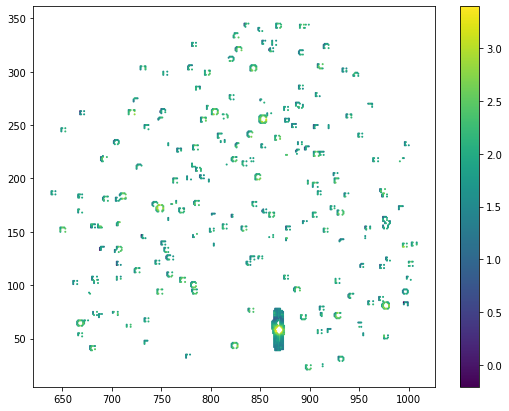

In [323]:
plt.figure(figsize=(9,7))
cbar = plt.scatter(bkg_col, bkg_row, c=np.log10(bkg_flx[0]), s=1);
plt.colorbar(cbar)
# plt.xlim(800,900)
# plt.ylim(0, 100)

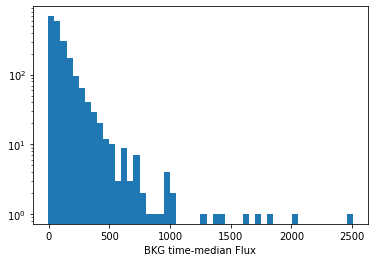

In [325]:
plt.hist(np.nanmedian(bkg_flux, axis=0), bins=50);
plt.xlabel("BKG time-median Flux")
plt.yscale("log")

<ipython-input-337-6cb875a54874>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cbar = plt.pcolormesh(time_mesh[machine_faint_pix], pix_mesh[machine_faint_pix],


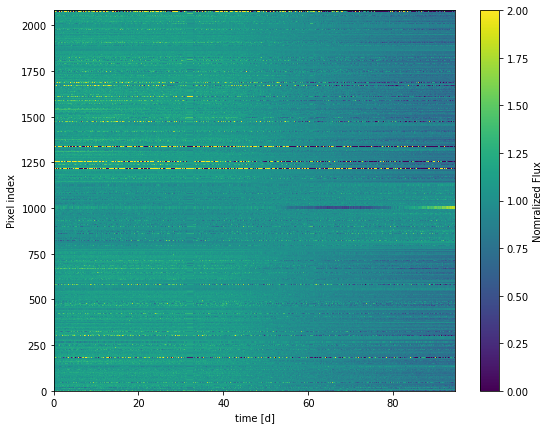

In [337]:
time_mesh, pix_mesh = np.meshgrid(machine.time - machine.time.min(), np.arange(bkg_flux.shape[1]))
#  clipping bright pixels
machine_faint_pix = np.nanmax(bkg_flux, axis=0) < 100

plt.figure(figsize=(9,7))
cbar = plt.pcolormesh(time_mesh[machine_faint_pix], pix_mesh[machine_faint_pix], 
                      bkg_flux.T[machine_faint_pix]/(bkg_flux.T.mean(axis=1)[machine_faint_pix][:, None]),
                     vmin=0, vmax=2)
plt.colorbar(cbar, label="Nomralized Flux")
plt.xlabel("time [d]")
plt.ylabel("Pixel index")
plt.show()

## ANC-ENG BKG files

to download Mission BKG files for Q5 Ch44

curl --globoff --location-trusted -f --progress-bar --create-dirs -C - --output 'bkg/2010/kplr134-2010078095331_bkg.fits.gz' 'https://archive.stsci.edu/missions/kepler/bkg/2010/kplr134-2010078095331_bkg.fits.gz'
curl --globoff --location-trusted -f --progress-bar --create-dirs -C - --output 'bkg/2010/kplr134-2010174085026_bkg.fits.gz' 'https://archive.stsci.edu/missions/kepler/bkg/2010/kplr134-2010174085026_bkg.fits.gz'
curl --globoff --location-trusted -f --progress-bar --create-dirs -C - --output 'bkg/2010/kplr134-2010265121752_bkg.fits.gz' 'https://archive.stsci.edu/missions/kepler/bkg/2010/kplr134-2010265121752_bkg.fits.gz'
curl --globoff --location-trusted -f --progress-bar --create-dirs -C - --output 'bkg/2010/kplr134-2010355172524_bkg.fits.gz' 'https://archive.stsci.edu/missions/kepler/bkg/2010/kplr134-2010355172524_bkg.fits.gz'

In [150]:
bkg_files = sorted(glob("/Users/jorgemarpa/Work/BAERI/ADAP/data/kepler/bkg/2010/kplr134*_bkg.fits.gz"))
len(bkg_files)

4

In [151]:
hdu = fits.open(bkg_files[1])
hdu.info()

Filename: /Users/jorgemarpa/Work/BAERI/ADAP/data/kepler/bkg/2010/kplr134-2010174085026_bkg.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   ()      
  1  BACKGROUND    1 BinTableHDU    108   4634R x 12C   [D, 4200D, J, 4200J, 4200E, 4200E, 15D, 225D, 4200E, J, 4200E, 4200E]   
  2  PIXELS        1 BinTableHDU     54   4200R x 2C   [J, J]   


In [152]:
hdu[0].header, hdu[1].header, hdu[2].header

(SIMPLE  =                    T / conforms to FITS standards                     
 BITPIX  =                    8 / array data type                                
 NAXIS   =                    0 / number of array dimensions                     
 EXTEND  =                    T / file contains extensions                       
 NEXTEND =                    2 / number of standard extensions                  
 EXTNAME = 'PRIMARY '           / name of extension                              
 EXTVER  =                    1 / extension version number (not format version)  
 ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
 DATE    = '2015-09-17'         / file creation date.                            
 CREATOR = '885131 BackgroundPixelExporter' / pipeline job and program used to pr
 PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.23 r60353' / SW version   
 FILEVER = '3.0     '           / file format version                            
 TIMVERSN= 'OGIP

In [161]:
pixels = Table.read(bkg_files[1], hdu=2).to_pandas()
background = Table.read(bkg_files[1], hdu=1)

In [305]:
cadence_mask= np.in1d(machine.tpfs[0].time.jd, machine.time)
cadence_no_machine = machine.tpfs[0].cadenceno[cadence_mask]
mission_mask = np.in1d(background["CADENCENO"].data.data, cadence_no_machine)

mission_bkg = background["FLUX"].data.data[mission_mask]
mission_bkge = background["FLUX_ERR"].data.data[mission_mask]

In [340]:
np.percentile(mission_bkg, 99)

238.97064208984375

<ipython-input-345-d30e86a907e2>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cbar = plt.pcolormesh(time_mesh[mission_faint_pix], pix_mesh[mission_faint_pix],


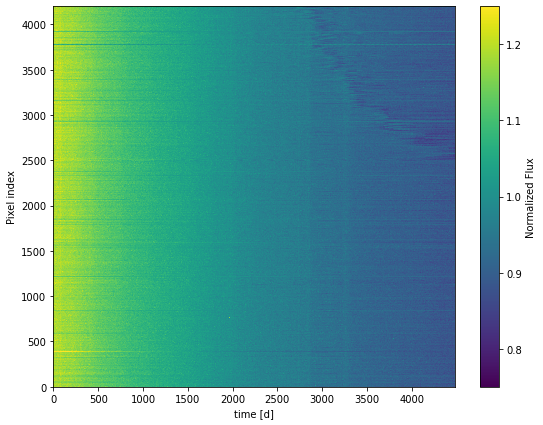

In [345]:
time_mesh, pix_mesh = np.meshgrid(np.arange(mission_bkg.shape[0]), np.arange(mission_bkg.shape[1]))
#  clipping bright pixels
mission_faint_pix = np.nanmax(mission_bkg, axis=0) < 1000

plt.figure(figsize=(9,7))
cbar = plt.pcolormesh(time_mesh[mission_faint_pix], pix_mesh[mission_faint_pix], 
                      mission_bkg.T[mission_faint_pix]/(mission_bkg.T.mean(axis=1)[mission_faint_pix][:, None]),
                      vmin=.75, vmax=1.25)
plt.colorbar(cbar, label="Normalized Flux")
plt.xlabel("time [d]")
plt.ylabel("Pixel index")
plt.show()

Text(0, 0.5, 'Median Pixel Flux [-e/s]')

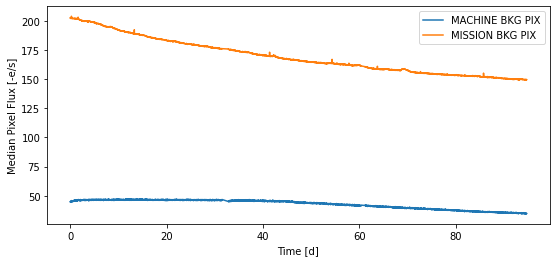

In [301]:
plt.figure(figsize=(9,4))
plt.plot(machine.time-machine.time.min(),
         np.nanmedian(bkg_flux[:, machine_faint_pix], axis=1), 
         label="MACHINE BKG PIX")
plt.plot(machine.time-machine.time.min(), 
         np.nanmedian(mission_bkg[:, mission_faint_pix], axis=1), 
         label="MISSION BKG PIX")
plt.legend()
plt.xlabel("Time [d]")
plt.ylabel("Median Pixel Flux [-e/s]")

<AxesSubplot:title={'center':'Target ID: 9150728, Cadence: 16373'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

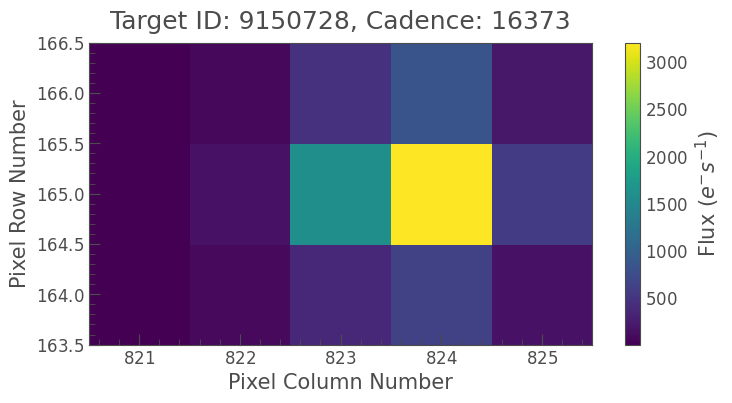

In [346]:
machine.tpfs[0].plot()

In [318]:
# bkg flux from tpfs

np.median(machine.tpfs[0].flux_bkg.value[cadence_mask].reshape(cadence_mask.sum(), -1), axis=1)

(4487,)

In [312]:
cadence_mask.sum()

4487